In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve, auc

import ml_utils as ml

# Load Data

In [2]:
# import the Titanic dataset
titanic_train = pd.read_csv("data/titanic-train.csv")
titanic_test  = pd.read_csv("data/titanic-test.csv")  

# import the Housing dataset
housing_train = pd.read_csv("data/housing-train.csv")
housing_test  = pd.read_csv("data/housing-test.csv")

## Clean up the Data

In [3]:
# encode the sex of the passengers
titanic_train.Sex = titanic_train.Sex.map({ 'male' : 0, 'female' : 1 }).astype(int)

# replace missing ages with the median
titanic_train.Age = titanic_train.Age.fillna(titanic_train.Age.median())

# remove some oddly large fares
titanic_train = titanic_train[titanic_train.Fare < 300]

# log transform the fare
titanic_train['logFare'] = np.log1p(titanic_train.Fare)

# fill in passengers without cabins
titanic_train.Cabin = titanic_train.Cabin.fillna(value='None')
titanic_train['has_cabin'] = [0 if x == 'None' else 1 for x in titanic_train.Cabin]

# fill in embarked with the mode
titanic_train.Embarked = titanic_train.Embarked.fillna(value=titanic_train.Embarked.mode()[0])

# turn Embarked into dummy variables
titanic_train = ml.append_dummies(titanic_train, ['Embarked'])

# Feature Importance

In [4]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'logFare', 'has_cabin', 'Q', 'S'] 
target   = 'Survived'
logreg = ml.Pipeline([('robust', RobustScaler()), ('clf', ml.LogisticRegression())])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(titanic_train[features], titanic_train[target], test_size=0.3, random_state=1)
logreg.fit(X_train, y_train);
logreg.summary(features)

       Name|    Coef.| Std.Err.|  z-score|  p-value|   [0.025    0.975]|  Signif.
-------------------------------------------------------------------------------------
Intercept  | -1.9369 |  0.2143 | -9.0405 |  0.0000 | [-2.3569  -1.5170]|   True
Pclass     | -0.6056 |  0.2310 | -2.6209 |  0.0088 | [-1.0584  -0.1527]|   True
Sex        |  2.4510 |  0.2368 | 10.3505 |  0.0000 | [ 1.9869   2.9151]|   True
Age        | -0.6677 |  0.1224 | -5.4532 |  0.0000 | [-0.9077  -0.4277]|   True
SibSp      | -0.3398 |  0.1364 | -2.4914 |  0.0127 | [-0.6072  -0.0725]|   True
Parch      | -0.1218 |  0.1403 | -0.8677 |  0.3856 | [-0.3968   0.1533]|  False
logFare    |  0.3749 |  0.2406 |  1.5583 |  0.1192 | [-0.0966   0.8465]|  False
has_cabin  |  0.6175 |  0.3658 |  1.6882 |  0.0914 | [-0.0994   1.3345]|  False
Q          | -0.1765 |  0.4519 | -0.3906 |  0.6961 | [-1.0622   0.7092]|  False
S          | -0.4144 |  0.2929 | -1.4146 |  0.1572 | [-0.9885   0.1598]|  False


# Train Models

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [8]:
# classifiers to tune
classifiers = {'LogReg'         : ml.Pipeline([('robust', RobustScaler()), ('clf', ml.LogisticRegression())]),
               'SVC-RBF'        : ml.Pipeline([('robust', RobustScaler()), ('clf', SVC(probability=True))]),
               'GaussianNB'     : ml.Pipeline([('clf', GaussianNB())]),
               'BernoulliNB'    : ml.Pipeline([('clf', BernoulliNB())]),
               'DecisionTree'   : ml.Pipeline([('clf', DecisionTreeClassifier())]),
               'XGBClassifier'  : ml.Pipeline([('clf', XGBClassifier())]),
               'LGBMClassifier' : ml.Pipeline([('clf', LGBMClassifier())])
              }
               
# tunable hyperparameters
C_s = np.logspace(-3, 2, 6) # range for regularization parameters
parameters  = {'LogReg'        : {'clf__penalty' : ['l1','l2'], 
                                  'clf__C'       : C_s},
               'SVC-RBF'       : {'clf__C'       : C_s,
                                  'clf__gamma'   : C_s},
               'GaussianNB'    : {},
               'BernoulliNB'   : {'clf__alpha'   : C_s},
               'DecisionTree'  : {'clf__max_depth'        : [3, 4, 6, 8, 10]},
               'XGBClassifier' : {
                                  'clf__learning_rate'    : [0.02, 0.04, 0.06, 0.08, 0.1], 
                                  'clf__colsample_bytree' : [0.4, 0.6, 0.8, 1.0]
                                 },
               'LGBMClassifier': {'clf__learning_rate'    : [0.02, 0.04, 0.06, 0.08, 0.1] }
              }

# hyperparameter tuning strategies
cv_strategy = {'LogReg'         : 'grid',
               'SVC-RBF'        : 'grid',
               'GaussianNB'     : 'grid',
               'BernoulliNB'    : 'grid',
               'DecisionTree'   : 'grid',
               'XGBClassifier'  : 'grid',
               'LGBMClassifier' : 'grid'
              }

# define the metrics we'll use to score the different parameters on
scores = ['accuracy']

# features and target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'logFare', 'has_cabin', 'Q', 'S'] 
target   = 'Survived'

# target names
target_names = ['Died', 'Lived']

## Cross Validation

In [9]:
# get the training and test sets
X_train, X_test, y_train, y_test = train_test_split(titanic_train[features], titanic_train[target], 
                                                    test_size=0.3, random_state=1)

# train all the base classifiers
trained_models = {}
for name, clf in classifiers.items():
    print("Training {}\n".format(name))
    trained_models[name] = ml.hyperparam_search(clf, parameters[name], scores, X_train, 
                                                X_test, y_train, y_test, cv_strategy[name])

Training LogReg

Best parameters set found:

{'clf__C': 10.0, 'clf__penalty': 'l1'}

Grid scores:

0.625 (+/-0.098) for {'clf__C': 0.001, 'clf__penalty': 'l1'}
0.768 (+/-0.104) for {'clf__C': 0.001, 'clf__penalty': 'l2'}
0.625 (+/-0.098) for {'clf__C': 0.01, 'clf__penalty': 'l1'}
0.787 (+/-0.084) for {'clf__C': 0.01, 'clf__penalty': 'l2'}
0.791 (+/-0.042) for {'clf__C': 0.1, 'clf__penalty': 'l1'}
0.794 (+/-0.041) for {'clf__C': 0.1, 'clf__penalty': 'l2'}
0.802 (+/-0.041) for {'clf__C': 1.0, 'clf__penalty': 'l1'}
0.800 (+/-0.046) for {'clf__C': 1.0, 'clf__penalty': 'l2'}
0.804 (+/-0.043) for {'clf__C': 10.0, 'clf__penalty': 'l1'}
0.804 (+/-0.043) for {'clf__C': 10.0, 'clf__penalty': 'l2'}
0.804 (+/-0.043) for {'clf__C': 100.0, 'clf__penalty': 'l1'}
0.804 (+/-0.043) for {'clf__C': 100.0, 'clf__penalty': 'l2'}

Training SVC-RBF

Best parameters set found:

{'clf__C': 100.0, 'clf__gamma': 0.01}

Grid scores:

0.625 (+/-0.098) for {'clf__C': 0.001, 'clf__gamma': 0.001}
0.625 (+/-0.098) for 

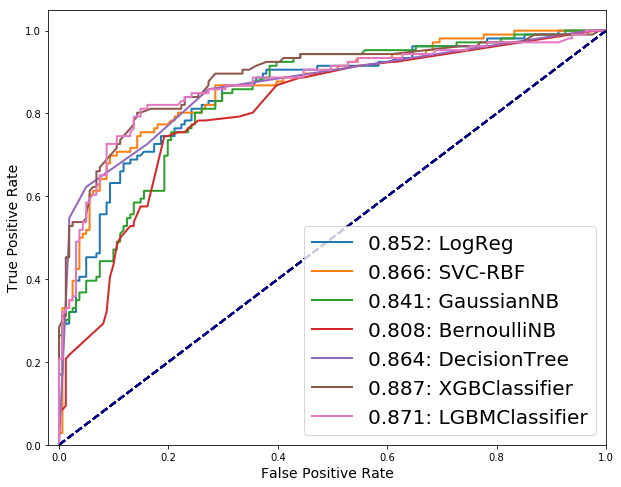

In [10]:
ml.plot_roc(trained_models, X_test, y_test)

## Nested Cross Validation

In [11]:
# train all the base classifiers
best_params = {}
for name, clf in classifiers.items():
    print("\nTraining {}\n".format(name))
    best_params[name] = ml.nested_cv(clf, parameters[name], titanic_train, features, target, strategy=cv_strategy[name])
    clf.set_params(**best_params[name])


Training LogReg

Best parameter set found:

{'clf__C': 1.0, 'clf__penalty': 'l1'}

Grid scores:

0.843 for {'clf__C': 0.1, 'clf__penalty': 'l2'}
0.775 for {'clf__C': 1.0, 'clf__penalty': 'l2'}
0.798 for {'clf__C': 1.0, 'clf__penalty': 'l2'}
0.764 for {'clf__C': 1.0, 'clf__penalty': 'l1'}
0.809 for {'clf__C': 1.0, 'clf__penalty': 'l1'}
0.798 for {'clf__C': 1.0, 'clf__penalty': 'l2'}
0.775 for {'clf__C': 0.1, 'clf__penalty': 'l2'}
0.697 for {'clf__C': 1.0, 'clf__penalty': 'l1'}
0.898 for {'clf__C': 10.0, 'clf__penalty': 'l2'}
0.795 for {'clf__C': 10.0, 'clf__penalty': 'l1'}

Training SVC-RBF

Best parameter set found:

{'clf__C': 1.0, 'clf__gamma': 0.1}

Grid scores:

0.787 for {'clf__C': 1.0, 'clf__gamma': 0.1}
0.753 for {'clf__C': 1.0, 'clf__gamma': 0.1}
0.876 for {'clf__C': 1.0, 'clf__gamma': 0.1}
0.820 for {'clf__C': 1.0, 'clf__gamma': 0.1}
0.831 for {'clf__C': 10.0, 'clf__gamma': 0.1}
0.798 for {'clf__C': 1.0, 'clf__gamma': 0.1}
0.809 for {'clf__C': 1.0, 'clf__gamma': 0.1}
0.831 fo

In [12]:
best_params

{'LogReg': {'clf__C': 1.0, 'clf__penalty': 'l1'},
 'SVC-RBF': {'clf__C': 1.0, 'clf__gamma': 0.1},
 'GaussianNB': {},
 'BernoulliNB': {'clf__alpha': 0.001},
 'DecisionTree': {'clf__max_depth': 3},
 'XGBClassifier': {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.08},
 'LGBMClassifier': {'clf__learning_rate': 0.02}}

## Simple Averaged Model

In [13]:
averaged_model = ml.AverageClassifierModels(models = classifiers.values())

In [ ]:
# split the training and test set
X_train, X_test, y_train, y_test = train_test_split(titanic_train[features], titanic_train[target], 
                                                    test_size=0.3, random_state=1)

averaged_model.fit(X_train, y_train);

In [ ]:
ml.plot_roc(averaged_model, X_test, y_test, name='Averaged Model')

# Boosted Models

In [ ]:
boosted_model = ml.BoostedClassifierModels(models = classifiers.values())

In [ ]:
# train a boosted ensemble using different splits of the data
boosted_model.fit(titanic_train[features], titanic_train[target]);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(titanic_train[features], titanic_train[target], 
                                                    test_size=0.3, random_state=123)

ml.plot_roc(boosted_model, X_test, y_test, name='Boosted Model')

# Stacked Models

In [ ]:
stacked = pd.DataFrame()

In [ ]:
for name, clf in classifiers.items():
    stacked[name] = clf.predict_proba(titanic_train[features])[:,1]
stacked['target'] = titanic_train[target]

In [ ]:
stacked.head()

In [ ]:
import seaborn as sns
sns.heatmap(stacked.corr(), annot=True);

In [53]:
from sklearn.linear_model import LogisticRegression


stacked_feats = list(classifiers.keys())
target   = 'target'
logreg = LogisticRegression()

In [54]:
X_train, X_test, y_train, y_test = train_test_split(stacked[stacked_feats], stacked['target'], 
                                                    test_size=0.3, random_state=1)

In [58]:
logreg.fit(X_train, y_train);

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
clf.predict_proba(titanic_train[features])[:,1]